Autores: Adrian Rubio Pintado y Marcos Vázquez Martín

In [1]:
%load_ext autoreload
%autoreload 2

# Load packages
import numpy as np
#import sde_solvers as sde
from scipy import stats
import matplotlib.pyplot as plt
import stochastic_plots as stoch

# Euler integration scheme for ODE's

In [4]:
def ode_euler(t0, x0, T, a, N):

    dT = T / N # size of simulation step
    
    # Initialize solution array
    t = np.linspace(t0, t0+T, N+1) # integration grid
    X = np.zeros(N+1)
    
    # Initial condition
    X[0] = x0
 
    # Integration of the ODE
    for n in range(N):
        X[n+1] = X[n] + a(t[n], X[n])*dT
        
    return (t, X)

In [29]:
def euler_maruyana(t0, x0, T, a, b, M, N):
    dt = T / N # size of simulation step
    
    # Initialize solution array
    t = np.linspace(t0, t0+T, N+1) # integration grid
    X = np.zeros((M,N+1))
    
    #Initial condition
    X[:, 0] = np.full(M, x0)
    
    for i in range(N): 
        X[:, i+1] =  X[:, i] + a(t[i], X[:, i]) * dt + b(t[i], X[:,i]*np.random.normal(loc=0.0, scale=np.sqrt(dt), size=M))
                                                        
    return t, X

In [35]:
def dW(delta_t, M):
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t), size = M)
def b2(t,x): return sigma**2*x

def milstein(t0, x0, T, a, b, db_dx, M, N):
    dt = T/N  # size of simulation step

    # Initialize solution array
    t = np.linspace(t0, t0 + T, N + 1)  # integration grid
    X = np.zeros((M, N + 1))

    # Initial condition
    X[:, 0] = np.full(M, x0)
    
    
    for i in range(N):
        X[:, i + 1] = X[:, i] + a(t[i], X[:, i])*dt + b(t[i], X[:, i])*dW(dt,M)+  0.5*b2(t[i], X[:, i])* (dW(dt,M)**2 - dt)
        
    return t, X

In [2]:
def simulate_jump_process(t0, T, simulator_arrival_times, simulator_jumps, M):
    time_of_jumps =  list(map(lambda _: simulator_arrival_times(t0, T), list(range(M))))
    sizes_of_jumps = list(map(lambda x: simulator_jumps(len(x)), time_of_jumps))
    return time_of_jumps, sizes_of_jumps

In [168]:
def euler_jump_diffusion(t0, x0, T, a, b, c, simulator_jump_process, M, N):
    dt = T/N  # size of simulation step
    
    # Initialize solution array
    t = np.linspace(t0, t0 + T, N + 1)  # integration grid
    X = np.zeros((M, N + 1))
    # Initial condition
    X[:, 0] = np.full(M, x0)
    
    
    times_of_jumps, sizes_of_jumps = simulator_jump_process(t0, T, M)
    

    # Para cada simulacion
    for n in range(N):

        # Integrate from t to t+\inc T
        integrate_times = [(tau>t[n])*(tau<t[n+1]) for tau in times_of_jumps]

        # Donde hay saltos
        inside_time_jumps = list(map(lambda x: bool(x.sum()), integrate_times))
        
        tau_ = np.full(M, t[n])
        Xtau_ = X[:, n]

        # Intervalos donde hay salto
        for m in np.where(inside_time_jumps)[0]:
            tau, Y  = times_of_jumps[m][integrate_times[m]], sizes_of_jumps[m][integrate_times[m]]
            Z, dT_jump = np.random.randn(), tau - tau_[m]
            Stau_ = Xtau_[m] + a(tau_[m],Xtau_[m])*dT_jump + b(tau_[m], Xtau_[m])*np.sqrt(dT_jump)*Z
            tau_[m] = tau[-1]
            Xtau_[m] = Stau_[-1] + c(tau_[m], Stau_[-1])*Y[-1]

        # Paso siguiente
        Z = np.random.randn(M)
        dT_jump = t[n + 1] - tau_
        X[:, n + 1] = Xtau_ + a(tau_, Xtau_)*dT_jump + b(tau_, Xtau_)*np.sqrt(dT_jump)*Z
        
    return t, X

# Integration schemes for SDE's

In [5]:
# Define SDE
mu = 1.3
sigma = 0.4
def a(t,x): return mu*x
def b(t,x): return sigma*x
def db_dx(t,x): return sigma

# Define initial conditions
t0, x0 = 0.0, 100.0
# Define the simulation parameters 
M = 10000 # Number of trajectories for simulation
T = 2.0   # Length of simulation interval
N = 1000  # Number of steps in simulation

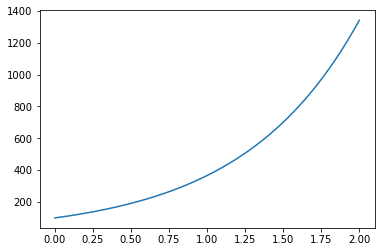

In [6]:
t, X_mean = ode_euler(t0, x0, T, a, N)
_ = plt.plot(t, X_mean)

## Stochastic Euler integration (Euler- Maruyana) scheme

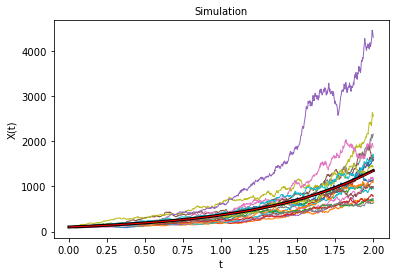

In [5]:
# Carry out simulation
t, X_euler = sde.euler_maruyana(t0, x0, T, a, b, M, N)

# Plot trajectories 
stoch.plot_trajectories(t, X_euler, fig_num=1)
_ = plt.plot(t, X_mean, linewidth=1, color='r')


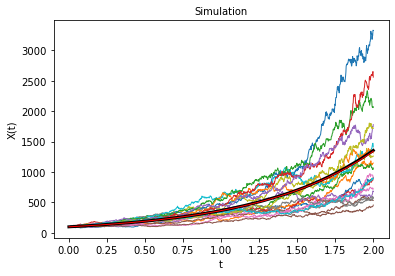

In [33]:
# Carry out simulation
t, X_euler = euler_maruyana(t0, x0, T, a, b, M, N)

# Plot trajectories 
stoch.plot_trajectories(t, X_euler, fig_num=1)
_ = plt.plot(t, X_mean, linewidth=1, color='r')

## Milstein integration sheme

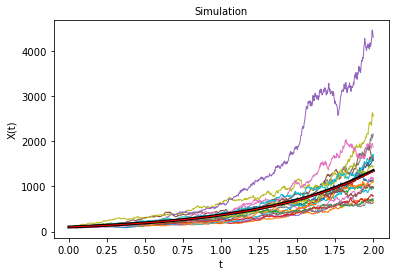

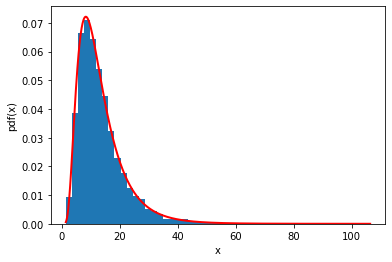

In [6]:
t, X_milstein = sde.milstein(t0, x0, T, a, b, db_dx, M, N)

# Plot trajectories 
stoch.plot_trajectories(t, X_euler, fig_num=1) 
plt.plot(t, np.mean(X_milstein, axis=0), linewidth=1, color='r')

# Plot histogram 
xT = X_euler[:,-1]
def pdf(x): return stats.lognorm.pdf(x, 
                           sigma*np.sqrt(T), 0.0, np.exp((mu - 0.5*sigma**2)*T))
stoch.plot_pdf(xT/x0, pdf, fig_num=2)

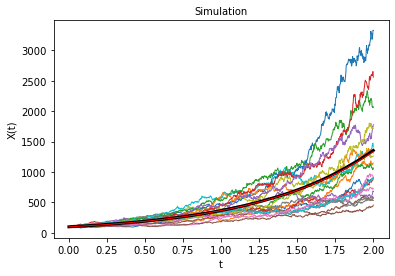

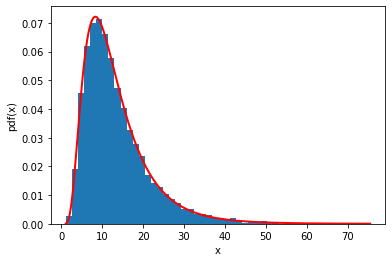

In [37]:
t, X_milstein = milstein(t0, x0, T, a, b, db_dx, M, N)

# Plot trajectories 
stoch.plot_trajectories(t, X_euler, fig_num=1) 
plt.plot(t, np.mean(X_milstein, axis=0), linewidth=1, color='r')

# Plot histogram 
xT = X_euler[:,-1]
def pdf(x): return stats.lognorm.pdf(x, 
                           sigma*np.sqrt(T), 0.0, np.exp((mu - 0.5*sigma**2)*T))
stoch.plot_pdf(xT/x0, pdf, fig_num=2)

## Jump simulator

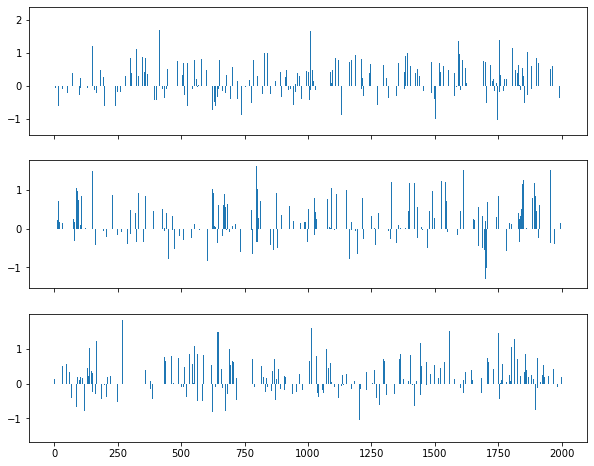

In [7]:
import arrival_process_simulation as arrival
lambda_rate = 0.5
beta_scale = 1.0/lambda_rate 
def simulator_arrival_times(t0, T): 
    return  arrival.simulate_poisson(t0, t0 + T, lambda_rate, M = 1)[0]
def simulator_jump_sizes(N): return 0.2 + 0.5*np.random.randn(N)

def simulator_jump_process(t0, T, M): 
    return sde.simulate_jump_process(t0, T,
                                     simulator_arrival_times, 
                                     simulator_jump_sizes, 
                                     M)

t0 = 0.0
T = 2000.0
M = 3
times_of_jumps, sizes_of_jumps = simulator_jump_process(t0, T, M)

fig, axs = plt.subplots(M, sharex=True, num=1, figsize=(10, 8))
for m in range(M):
     axs[m].bar(times_of_jumps[m], sizes_of_jumps[m])

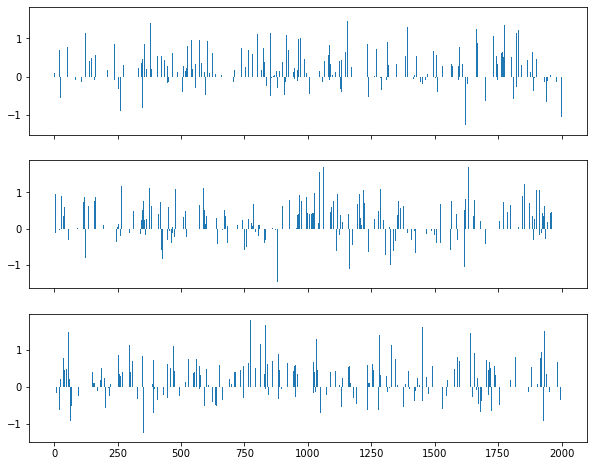

In [3]:
import arrival_process_simulation as arrival
lambda_rate = 0.5
beta_scale = 1.0/lambda_rate 
def simulator_arrival_times(t0, T): 
    return  arrival.simulate_poisson(t0, t0 + T, lambda_rate, M = 1)[0]
def simulator_jump_sizes(N): return 0.2 + 0.5*np.random.randn(N)

def simulator_jump_process(t0, T, M): 
    return simulate_jump_process(t0, T,
                                     simulator_arrival_times, 
                                     simulator_jump_sizes, 
                                     M)

t0 = 0.0
T = 2000.0
M = 3
times_of_jumps, sizes_of_jumps = simulator_jump_process(t0, T, M)

fig, axs = plt.subplots(M, sharex=True, num=1, figsize=(10, 8))
for m in range(M):
     axs[m].bar(times_of_jumps[m], sizes_of_jumps[m])

## Jump-diffusion SDE

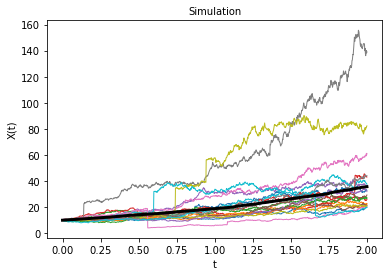

In [8]:
## Define jump-diffusion SDE
def a(t,x): return 5.0*x/x0
def b(t,x): return 3.0*x/x0
def c(t,x): return 10.0*x/x0

## Define the conditions for the simulation

t0 = 0
x0 = 10.0
T = 2.0
N = 1000
M = 500


t, X = sde.euler_jump_diffusion(t0, x0, T, a, b, c, 
                         simulator_jump_process, 
                         M, N)

stoch.plot_trajectories(t, X, fig_num=10)


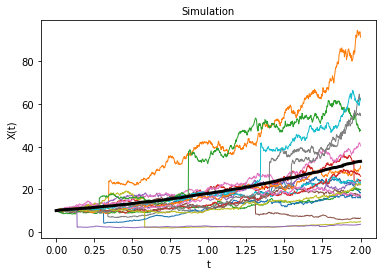

In [172]:
## Define jump-diffusion SDE
def a(t,x): return 5.0*x/x0
def b(t,x): return 3.0*x/x0
def c(t,x): return 10.0*x/x0

## Define the conditions for the simulation

t0 = 0
x0 = 10.0
T = 2.0
N = 1000
M = 500


t, X = euler_jump_diffusion(t0, x0, T, a, b, c, 
                         simulator_jump_process, 
                         M, N)

stoch.plot_trajectories(t, X, fig_num=10)